In [1]:
# Affan Shoukat, Yale University 
# Estimating population herd immunity in the United States
# Final numbers be differ slightly in manuscript and running this notebook due to stochasticity and random number generators
# Options: set env variable JULIA_NUM_THREADS to use multithreading for speeding up simulations

# activate local environment using Project/Manifest files for full reproducibility
using Pkg; Pkg.activate(".")
using Distributions
using Random
using Gnuplot
using Statistics
using CSV 
using DataFrames
using Dates
using StatsBase
using Base.Threads
using DelimitedFiles

Gnuplot.options.mime[MIME"text/html"] = "svg enhanced standalone mouse size 1200,400"; # set a default Gnuplot/Jupyter set size here 
println("enabled threads: $(Threads.nthreads())") # check number of threads

  Activating environment at `/mnt/c/Users/affan/OneDrive/Documents/postdoc_projects/2019-ncov/population_immunity/Project.toml`


enabled threads: 8


In [49]:
# define constant distributions
# age groups for analysis: 0-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80+
const ifr_tdd_distr = Truncated(Gamma(3.385, 1/0.21), -Inf, 75)  # distributions for the incubation period + time to death period
const ift_inc_distr = Truncated(LogNormal(1.434, 0.661), -Inf, 25)

# IFR values 
# The scale parameter of the distributions was set to 0.1, which allows for the range of IFR estimates to be considered in the model sampling
cdc_ifrs = LogNormal.(log.([0.002, 0.002, 0.05, 0.05, 0.05, 0.6, 9, 9, 9]), 0.1)
driscoll_ifrs = LogNormal.(log.([0.002, 0.003, 0.013, 0.04, 0.12, 0.32, 1.07, 3.2, 8.29]), 0.1)
verity_ifrs = LogNormal.(log.([0.00161, 0.00695, 0.0309, 0.0844, 0.161, 0.595, 1.93, 4.28, 7.80]), 0.1)

# proportion of deaths for each age group 
# source: https://www.cdc.gov/nchs/nvss/vsrr/covid_weekly/index.htm#SexAndAge
const pdeaths = (0.03, 0.025, 1.09, 2.1, 3.1, 15.9, 22.3, 25.4, 30.055) ./ 100  

# test the maximum of tdd + inc, should not exceed 100 days for stability purposes. 
_tddlagvals = rand(ifr_tdd_distr, 10000) .+ rand(ift_inc_distr, 10000) 
length(findall(x -> x >= 100, _tddlagvals)) != 0 && error("lag+incubation > 100")

false

In [50]:
# SCRIPT OPTIONS!! 
# once the following options are set, run the whole notebook to generate the results/plots
distr_to_use = verity_ifrs # set the distribution to use from above 
fileprefix = "verity"

"verity"

542×4 DataFrame
 Row │ Date        t      Cases     DailyDeaths 
     │ Date        Int64  Int64     Int64       
─────┼──────────────────────────────────────────
   1 │ 2020-01-21      1         1            0
   2 │ 2020-01-22      2         1            0
   3 │ 2020-01-23      3         1            0
   4 │ 2020-01-24      4         2            0
   5 │ 2020-01-25      5         3            0
   6 │ 2020-01-26      6         5            0
   7 │ 2020-01-27      7         5            0
   8 │ 2020-01-28      8         5            0
   9 │ 2020-01-29      9         5            0
  10 │ 2020-01-30     10         6            0
  11 │ 2020-01-31     11         7            0
  ⋮  │     ⋮         ⋮       ⋮           ⋮
 533 │ 2021-07-06    533  33714142          317
 534 │ 2021-07-07    534  33746559          322
 535 │ 2021-07-08    535  33769662          366
 536 │ 2021-07-09    536  33804834          407
 537 │ 2021-07-10    537  33813725           88
 538 │ 2021-07-11    538  

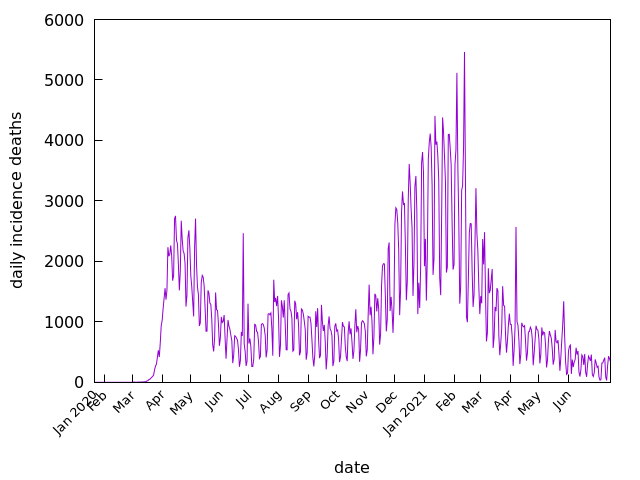

In [51]:
## read and plot the raw cases and dailydeaths
df = DataFrame(CSV.File("USData-July15.csv", dateformat="mm/dd/yyyy"))
#df.Date = Date.(df.Date, DateFormat("m/d/y"))
show(df)

@gp "reset" 
@gp :- "set xlabel 'date'"
@gp :- "set ylabel 'daily incidence deaths'"
@gp :- "set xtics ('Jan 2020' 1, 'Feb' 12, 'Mar' 41, 'Apr' 72, 'May' 102, 'Jun' 133, 'Jul' 163, 'Aug' 194, 'Sep' 225, 'Oct' 255, 'Nov' 286, 'Dec' 316, 'Jan 2021' 347, 'Feb' 378, 'Mar' 406, 'Apr' 437, 'May' 467, 'Jun' 498 )"
@gp :- "set xtics rotate by 45 right in font ', 10'"
@gp :- "set xtics noenhanced nomirror" # no escaping for strings :-
@gp :- "set ytics nomirror" :-
@gp :- 1:length(df.DailyDeaths) df.DailyDeaths "with lines notitle"

In [52]:
# lets do some basic analysis here to get a rough estimate of what the results look like 
for idst in [cdc_ifrs, driscoll_ifrs, verity_ifrs]
    _ifr_distr = idst
    aa = [(sum(df.DailyDeaths) .* pdeaths) ./ ([rand.(_ifr_distr)...] ./ 100) for i = 1:1000]
    avg = round.(mean(hcat(aa...), dims=2))
    min = round.(minimum(hcat(aa...), dims=2))
    max = round.(maximum(hcat(aa...), dims=2))
    #display(hcat(min, avg, max))
    println("mean $(sum(avg)) range ($(sum(min)) -- $(sum(max)))")
end

mean 1.15155299e8 range (8.3643924e7 -- 1.59373692e8)
mean 1.63403825e8 range (1.17108259e8 -- 2.26611135e8)
mean 9.1354112e7 range (6.6461612e7 -- 1.26448437e8)


In [53]:
# Main simulation function: Runs MC simulations and in each simulation, samples IFR, calculate infections, and calculate lag-times
function run_sims(ifr_distr) 
    # get minimum/maximum dates 
    datevec = collect((df.Date[1] - Day(100)):Day(1):df.Date[end])
    totalsims = 500
    resdf = Array{DataFrame, 1}(undef, totalsims) # create new dataframe to store the results    
    
    Threads.@threads for nsim in 1:totalsims
        res = DataFrame([:date => datevec, :deaths => 0, :sim => 0]) # create empty dataframe
        # for each row 
        lagarr = Array{Vector{Date}, 1}(undef, nrow(df))
        for (i, drow) in enumerate(eachrow(df))
            dths = drow[:DailyDeaths]
            ldate = drow[:Date]
            incs = rand(ift_inc_distr, dths) # sample incubation periods
            lags = rand(ifr_tdd_distr, dths) # sample tdd periods   
            lags = Int.(round.(lags .+ incs)) # add them together, round, convert to integer

            lagdates = ldate .- Dates.Day.(lags) # distribute the deaths to infection in previous days
            lagarr[i] = lagdates
            #lagarr[i] = StatsBase.countmap(lagdates) # sum up infections on same day
        end 

        _distdeaths = countmap(vcat(lagarr...))  # the dictionary of dates
        for dr in res.date        # res.date is the full date list from the minimum to maximum    
            if !(haskey(_distdeaths, dr))
                _distdeaths[dr] = 0 
            end
        end
 
        distdeaths = sort(_distdeaths)
        res.deaths .= values(distdeaths) # add to the dataframe
        res.sim .= nsim
        # calculate infections using sampled ifr
        samp_ifrs = pdeaths ./ (rand.(ifr_distr) ./ 100)
        agcolnames = [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9]
        transform!(res, [:deaths] => ByRow((dth) -> dth .* samp_ifrs) => agcolnames) # convert to per 100000
        res[!, :totalinfections] .= sum.(eachrow(res[:, 4:12]))
        resdf[nsim] = res
    end
    finaldf = vcat(resdf...)
end

# equivalent function, but very unoptimized function - takes very long to run, use above function 
function run_sims2() 
    # get minimum/maximum dates 
    datevec = collect((df.Date[1] - Day(100)):Day(1):df.Date[end])
    agcolnames = [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9]
    totalsims = 10
    resdf = Array{DataFrame, 1}(undef, totalsims) # create new dataframe to store the results    
    
    Threads.@threads for nsim in 1:totalsims        
        res = DataFrame([:date => datevec, :ag1 => 0, :ag2 => 0, :ag3 => 0, :ag4 => 0, :ag5 => 0, :ag6 => 0, :ag7 => 0, :ag8 => 0, :ag9 => 0, :sim => 0]) # create empty dataframe
        lagarr = Array{Vector{Date}, 2}(undef, nrow(df), 9) # for each row 
        for (i, drow) in enumerate(eachrow(df))
            dths = drow[:DailyDeaths]
            ldate = drow[:Date]
            
            samp_ifrs = pdeaths ./ (rand.(ifr_distr) ./ 100)
            totalinfecs = Int.(round.(dths .* samp_ifrs))
            
            for ag = 1:9 
                incs = rand(ift_inc_distr, totalinfecs[ag]) # sample incubation periods
                lags = rand(ifr_tdd_distr, totalinfecs[ag]) # sample tdd periods   
                lags = Int.(round.(lags .+ incs)) # add them together, round, convert to integer
                lagdates = ldate .- Dates.Day.(lags) # distribute the deaths to infection in previous days
                lagarr[i, ag] = lagdates 
            end
        end 
    
        for (xcol, ag) in zip(eachcol(lagarr), agcolnames) 
            _distdeaths = countmap(vcat(xcol...))  # the dictionary of dates
            for dr in res.date                     # res.date is the full date list from the minimum to maximum    
                if !(haskey(_distdeaths, dr))
                    _distdeaths[dr] = 0 
                end
            end
            distdeaths = sort(_distdeaths)
            res[!, ag] .= values(distdeaths)
            res[!, :sim] .= nsim
        end        
        res[!, :totalinfections] .= sum.(eachrow(res[:, 2:10]))
        resdf[nsim] = res
    end
    finaldf = vcat(resdf...)
end

run_sims2 (generic function with 1 method)

In [54]:
# run the simulations, about 3 minutes on i7 4 core, 8 thread
@time finaldf = run_sims(distr_to_use);

261.207743 seconds (23.24 M allocations: 12.161 GiB, 0.39% gc time, 0.02% compilation time)


cumulative infections: 9.148442115502279e7 (7.83502235256626e7 - 1.0581387602027915e8)


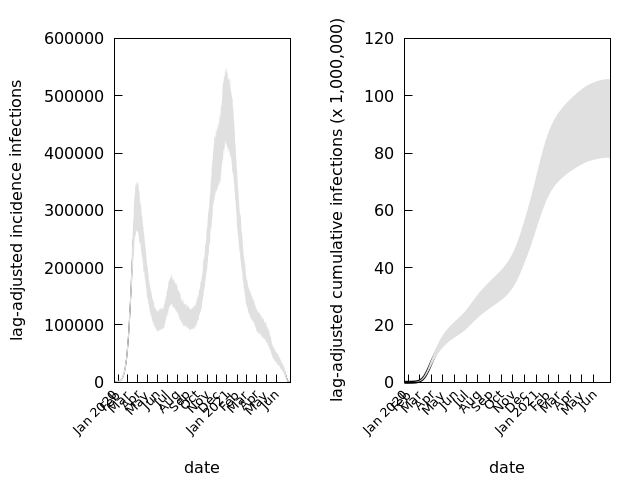

In [55]:
# take the mean, min, max of simulations, per day
mean_inf_df = combine(groupby(finaldf, [:date]), :totalinfections => (x -> (mean=mean(x), min=minimum(x), max=maximum(x))) => AsTable)  
# for computing lag times, we went back 100 days to make sure there is room for infections to be distributed. 
# but for plotting purposes we don't really need it nor do we need it for analysis
mean_inf_df = mean_inf_df[101:end, :]
xvals = 1:nrow(mean_inf_df)
ymeans, ymins, ymax = (mean_inf_df.mean, mean_inf_df.min, mean_inf_df.max)

# remember, we are removing the first 100 days here when printing this out
println("cumulative infections: $(sum(ymeans)) ($(sum(ymins)) - $(sum(ymax)))")  

# plot the mean lag-adjsuted infections 
Gnuplot.options.mime[MIME"text/html"] = "svg enhanced standalone mouse size 1200,400";
@gp "reset" 
@gp :- "set multiplot layout 1,2 title ''"
@gp :- "set xlabel 'date'"

@gp :- "set xtics ('Jan 2020' 1, 'Feb' 12, 'Mar' 41, 'Apr' 72, 'May' 102, 'Jun' 133, 'Jul' 163, 'Aug' 194, 'Sep' 225, 'Oct' 255, 'Nov' 286, 'Dec' 316, 'Jan 2021' 347, 'Feb' 378, 'Mar' 406, 'Apr' 437, 'May' 467, 'Jun' 498 )"
@gp :- "set xtics rotate by 45 right in font ', 10'"
@gp :- "set xtics noenhanced nomirror" # no escaping for strings :-
@gp :- "set ytics nomirror" :-

@gp :- 1 xvals ymeans "with lines notitle lc 'black'"
@gp :- 1 xvals ymins ymax "with filledcurves notitle fc 'grey' fs solid 0.5 border lc 'blue'"
@gp :- "set ylabel 'lag-adjusted incidence infections'"

@gp :- 2 xvals cumsum(ymeans) ./ 1000000 "with lines notitle  lc 'black' lw 3"
@gp :- 2 xvals cumsum(ymins) ./ 1000000 cumsum(ymax) ./ 1000000 "with filledcurves notitle fc 'grey' fs solid 0.5 border lc 'blue'"
@gp :- "set ylabel 'lag-adjusted cumulative infections (x 1,000,000)'"
display(@gp)
# save finaldf in csv files for Seyed to plot in matlab instead
# let's stack the columns and set up multiple files for him

agcolnames = [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9]
for ag in agcolnames 
    subdf = stack(finaldf, [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9], [:date, :sim])
    filter!(x -> x.variable == string(ag), subdf)
    subdf = unstack(subdf, :sim, :value)
    subdf = select(subdf, Not([:date, :variable]))
    CSV.write("$(fileprefix)_$(string(ag))_df.csv", subdf)
end

In [56]:
## MC calculation for determining the probability that an individual is infected but not vaccinated. 
function run_secondmc(totalindividuals, totalvaccinated, totalinfected) 
    Random.seed!(123)
    #totalindividuals = 100
    totalsims = 2001
    #totalvaccinated = 43
    #totalinfected = 38
    mat_vac = zeros(Int64, totalindividuals, totalsims)
    mat_inf = zeros(Int64, totalindividuals, totalsims)

    for nsim in 1:totalsims 
        sampled_vac = sample(1:totalindividuals, totalvaccinated, replace=false) # rand(1:totalindividuals, totalvaccinated)    
        mat_vac[sampled_vac, nsim] .= 1

        sampled_inf = sample(1:totalindividuals, totalinfected, replace=false) #rand(1:totalindividuals, totalinfected)    
        mat_inf[sampled_inf, nsim] .= 1
    end
    
    mat_sum =  mat_inf .- mat_vac  # whereever the entry is 1... that's what we want.. person is infected, and not vaccinated
    #display(mat_sum)
    #display(mat_vac) 
    #display(mat_inf)
    p_inf_notvac = [length(findall(x -> x == 1, c)) / totalinfected for c in eachcol(mat_sum)]
    p_inf_notvac
end 

run_secondmc (generic function with 1 method)

In [57]:
# Immunity calculation begins here
# these variables used later on as well, do not overwrite
pops = [39772578, 41852838, 129630156, 62925688, 54058263]
dose1 = [75568, 4185284, 11235730, 5034055, 4865244]  # first dose
dose2 = [103408, 10470898, 61309975, 41530954, 42884199] # second dose
eff_dose1 = 0.514
eff_dose2 = 0.861
eff_dose2m = 0.933
reinfection = 0.84

# first lets collapse the age groups to match the parameters for calculating immunity 
finaldf.cg1 = finaldf.ag1 
finaldf.cg2 = finaldf.ag2
finaldf.cg3 = finaldf.ag3 .+ finaldf.ag4 .+ finaldf.ag5
finaldf.cg4 = finaldf.ag6
finaldf.cg5 = finaldf.ag7 .+ finaldf.ag8 .+ finaldf.ag9

# lets take the mean/min/max of all simulations for the collasped age groups 
# this gives the total number of infections in those age groups (see bug check below) 
# but these infections include those that may be vaccinated as well and we would like to remove those to prevent double counting 
reducedag_inf = combine(groupby(finaldf, [:date]), [:cg1, :cg2, :cg3, :cg4, :cg5] => ((x1, x2, x3, x4, x5) -> (cg1_mean=mean(x1), cg2_mean=mean(x2), cg3_mean=mean(x3), cg4_mean=mean(x4), cg5_mean=mean(x5), 
                                                                                     cg1_low=minimum(x1), cg2_low=minimum(x2), cg3_low=minimum(x3), cg4_low=minimum(x4), cg5_low=minimum(x5),
                                                                                     cg1_hi=maximum(x1), cg2_hi=maximum(x2), cg3_hi=maximum(x3), cg4_hi=maximum(x4), cg5_hi=maximum(x5))) => AsTable)  

# sum up the means at the age group level
reducedag_inf_sums = [sum(reducedag_inf[1:(end), Symbol("cg$(i)_mean")]) for i = 1:5] 

# run the MC simulations for determining probability that individual is infected but not vaccinated 
# this is also done at the age group level. 
ol_lows = zeros(Float64, 5) 
ol_means = zeros(Float64, 5) 
ol_his = zeros(Float64, 5)
println("Probability of infected but not vaccinated (mean, lo, high) (per age group)\n")
for ag in 1:5
    popsize = pops[ag] 
    vac = Int(ceil(dose2[ag] / popsize * 1000))
    inf = Int(ceil(reducedag_inf_sums[ag] / popsize * 1000))    
    res = run_secondmc(1000, vac, inf)
    ol_lows[ag] = minimum(res)
    ol_means[ag] = mean(res)
    ol_his[ag] = maximum(res)
end

# save this data for Seyed's script (but we move on with our own equivalent analysis)

## we continue on below
println("means: $(round.(ol_means, digits=5))")
println("lows: $(round.(ol_lows, digits=5))")
println("highs: $(round.(ol_his, digits=5))")

writedlm("$(fileprefix)_probs_mcmc.csv", hcat(round.(ol_means, digits=5), round.(ol_lows, digits=5), round.(ol_his, digits=5)), ",", header=false)

Probability of infected but not vaccinated (mean, lo, high) (per age group)

means: [0.99707, 0.74789, 0.52684, 0.33963, 0.20622]
lows: [0.98966, 0.56604, 0.46524, 0.25287, 0.12863]
highs: [1.0, 0.92453, 0.59893, 0.43678, 0.29461]


In [58]:
# lets calculate the actual immunity

# the ol_means, ol_lows, and ol_his are the age-group specific probability for infected by not vaccinated 
# for all infections (prior to the last 90 days), multiply the "total number of infections" by this probability to remove those that are vaccinated. 
# (infections in the last 90 days should not be vaccinated and so there is no double counting there) 
inf_means = zeros(Float64, 5) 
inf_los = zeros(Float64, 5) 
inf_his = zeros(Float64, 5)
for i = 1:5    
    inf_means[i] = (sum(reducedag_inf[1:(end - 90), Symbol("cg$(i)_mean")]) * ol_means[i])  + sum(reducedag_inf[(end - 90):end, Symbol("cg$(i)_mean")])
    inf_los[i] =   (sum(reducedag_inf[1:(end - 90), Symbol("cg$(i)_low")]) * ol_lows[i]) + sum(reducedag_inf[(end - 90):end, Symbol("cg$(i)_low")])
    inf_his[i] =   (sum(reducedag_inf[1:(end - 90), Symbol("cg$(i)_hi")]) * ol_his[i]) + sum(reducedag_inf[(end - 90):end, Symbol("cg$(i)_hi")])
end

# the actual immunity is infections + vaccinations - (infections & vaccinations)
# first lets do at the age group level
immunities_mean = zeros(Float64, 5) 
immunities_lo = zeros(Float64, 5) 
immunities_hi = zeros(Float64, 5) 
for i = 1:5
    immunities_mean[i] =  (inf_means[i]*reinfection + dose1[i]*eff_dose1 + dose2[i]*eff_dose2)/pops[i]
    immunities_lo[i] =  (inf_los[i]*reinfection + dose1[i]*eff_dose1 + dose2[i]*eff_dose2)/pops[i]
    immunities_hi[i] =  (inf_his[i]*reinfection + dose1[i]*eff_dose1 + dose2[i]*eff_dose2)/pops[i]
end

println("means, lows and hi's of the age groups")
println("mean: $immunities_mean")
println("lo: $immunities_lo")
println("hi: $immunities_hi")

# do the overall 
overall_mean = (sum(inf_means) * reinfection + sum(dose1)*eff_dose1 + 0.58*sum(dose2)*eff_dose2 + 0.42*sum(dose2)*eff_dose2m) / sum(pops)
overall_lo = (sum(inf_los) * reinfection + sum(dose1)*eff_dose1 + 0.58*sum(dose2)*eff_dose2 + 0.42*sum(dose2)*eff_dose2m) / sum(pops)
overall_hi = (sum(inf_his) * reinfection + sum(dose1)*eff_dose1 + 0.58*sum(dose2)*eff_dose2 + 0.42*sum(dose2)*eff_dose2m) / sum(pops)

println("\noverall: $overall_mean ( $overall_lo - $overall_hi )")

means, lows and hi's of the age groups
mean: [0.2456770727715031, 0.3005341777804429, 0.6242066554813898, 0.6905589452946214, 0.7785313775137501]
lo: [0.1812203583427361, 0.2858166607639416, 0.5753184424313347, 0.6528869409429312, 0.7570813172527877]
hi: [0.34169735354902536, 0.3213115476205626, 0.697092978814135, 0.7535520993703482, 0.8114748025986926]

overall: 0.5896056292489317 ( 0.549857045916212 - 0.6501759809842663 )


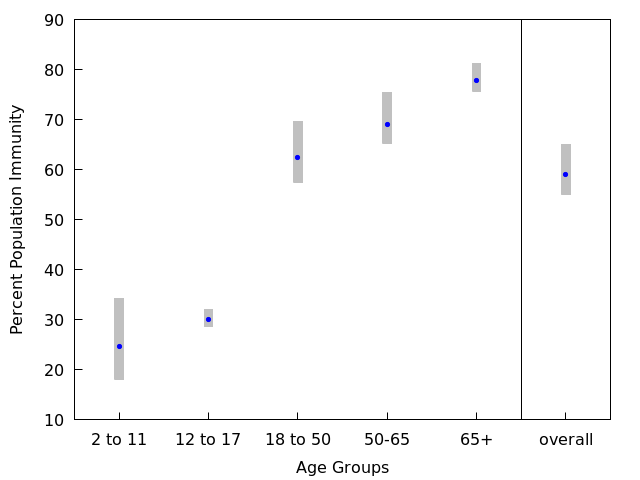

In [59]:
# Plot the Figure
# box plot args: x  box_min  whisker_min  whisker_high  box_high
# can also do # Data columns:X Min 1stQuartile Median 3rdQuartile Max
Gnuplot.options.mime[MIME"text/html"] = "svg enhanced standalone mouse size 350,400";
@gp "reset" 
@gp :- "set boxwidth 0.1 absolute"
@gp :- "set offsets 0.5, 0.5, 0, 0"
@gp :- "set autoscale xfix"
@gp :- "set style fill solid noborder"
@gp :- "set xtics ('2 to 11' 1, '12 to 17' 2, '18 to 50' 3, '50-65' 4, '65+' 5, 'overall' 6)"

@gp :- "set xtics noenhanced nomirror" # no escaping for strings :-
@gp :- "set ytics nomirror" 
@gp :- "set xlabel 'Age Groups'"
@gp :- "set ylabel 'Percent Population Immunity'"
# obj 1 is the entire plot
#@gp :- "set obj 1 rectangle behind from screen 0,0 to screen 1,1"
#@gp :- "set obj 1 fillstyle solid 1.0 fillcolor rgbcolor 'black'"

@gp :- 1:5 immunities_lo.*100  immunities_lo.*100 immunities_hi.*100   immunities_hi.*100   "w candlesticks notit linecolor rgb 'grey'" 
@gp :- 1:5 immunities_mean.*100 "with point notit pointtype 7 pointsize 0.7  lc rgb 'blue'"
@gp :- 6:6 overall_lo.*100  overall_lo.*100 overall_hi.*100   overall_hi.*100   "w candlesticks notit linecolor rgb 'grey'" 
@gp :- 6:6 overall_mean.*100 "with point notit pointtype 7 pointsize 0.7 lc rgb 'blue'"
#@gp :- "set arrow from 4.5,4 to 4.5,80 nohead lc rgb 'red'"
@gp :- "set arrow from 5.5, graph 0 to 5.5, graph 1 nohead"
